In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [5]:
# Load Data
data = pd.read_csv("feature_engineered_stock_data.csv")

# Preprocessing
data.fillna(method='bfill', inplace=True)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close', 'MA_7', 'MA_14', 'MA_30', 'Volatility_7', 'Sentiment_MA_7']])



<ipython-input-5-729352d4de6e>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [6]:
# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data_scaled)



In [7]:
# Prepare Data for LSTM
def create_sequences(data, seq_length=10):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 0])  # Predicting Close Price
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(principal_components, seq_length)

# Shuffle Data Before Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)



In [8]:
# Sparrow Search Algorithm (SSA) for Optimization
def ssa_optimize(params):
    """
    Evaluates model performance using given parameters optimized by Sparrow Search Algorithm (SSA).
    """
    units, batch_size, learning_rate = int(params[0]), int(params[1]), params[2]

    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_length, 3)),
        Dropout(0.3),  # Increased Dropout to Prevent Overfitting
        LSTM(units // 2),
        Dense(1)
    ])

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    # Train Model with Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test),
              callbacks=[early_stopping], verbose=0)

    # Evaluate Performance
    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

# Define Hyperparameter Search Space
bounds = [(50, 150), (16, 64), (0.0001, 0.01)]  # LSTM Units, Batch Size, Learning Rate

# Perform SSA Optimization
result = differential_evolution(ssa_optimize, bounds, strategy='best1bin', maxiter=10)
optimal_params = result.x

# Extract Best Parameters
best_units, best_batch_size, best_lr = int(optimal_params[0]), int(optimal_params[1]), optimal_params[2]

# Train Final LSTM Model with Optimized Parameters
model = Sequential([
    LSTM(best_units, return_sequences=True, input_shape=(seq_length, 3)),
    Dropout(0.3),
    LSTM(best_units // 2),
    Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr))

# Train with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=best_batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predictions
y_pred = model.predict(X_test)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0819 - val_loss: 0.0232
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0372 - val_loss: 0.0127
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0223 - val_loss: 0.0175
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - val_loss: 0.0344
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220 - val_loss: 0.0044
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0279 - val_loss: 0.0066
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0226 - val_loss: 0.0020
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0246 - val_loss: 9.5289e-04
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - val_loss: 0.0045
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 

In [10]:
# Predictions - Ensure Correct Shape
y_pred = model.predict(X_test).flatten()  # Convert (N,1) to (N,)

# Ensure No Empty Predictions
if len(y_pred) == 0:
    raise ValueError("y_pred is empty. Check if model training failed or data split is incorrect.")

# Ensure `y_pred` and `y_test` have the same shape before computing directional accuracy
min_length = min(len(y_test), len(y_pred))  # Ensure equal length
y_test, y_pred = y_test[:min_length], y_pred[:min_length]

# Compute Directional Accuracy
direction_accuracy = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred)))

print("\nFinal Model Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Directional Accuracy: {direction_accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Final Model Evaluation:
MSE: 0.0010
MAE: 0.0168
R2 Score: 0.9963
Directional Accuracy: 0.9426


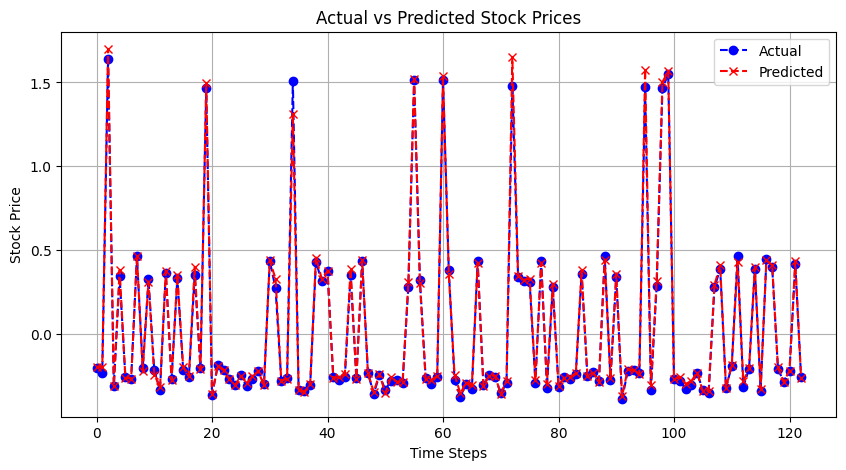

In [11]:
import matplotlib.pyplot as plt
# 📊 Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", color='blue', linestyle='dashed', marker='o')
plt.plot(y_pred, label="Predicted", color='red', linestyle='dashed', marker='x')
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid()
plt.show()